In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

In [2]:
# Load the dataset
data = pd.read_csv("Dataset.csv")  # Replace "your_dataset.csv" with your dataset path

In [3]:
# Exploratory Data Analysis (EDA)
print("Dataset shape:", data.shape)
print("Columns:", data.columns)
print("Data summary:\n", data.describe())
print("Class distribution:\n", data['Sentiment'].value_counts())

Dataset shape: (50000, 2)
Columns: Index(['Review', 'Sentiment'], dtype='object')
Data summary:
                                                    Review Sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
Class distribution:
 Sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [4]:
# Data preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(filtered_tokens)

data['Processed_Review'] = data['Review'].apply(preprocess_text)

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['Processed_Review'], data['Sentiment'], test_size=0.2, random_state=42)

In [6]:
# Tokenization and sequence padding for Keras
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [7]:
# Define the LSTM model
embedding_dim = 128
lstm_units = 64
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the model
history = model.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test_encoded), verbose=2)


Epoch 1/5
1250/1250 - 258s - loss: 0.3464 - accuracy: 0.8494 - val_loss: 0.2796 - val_accuracy: 0.8840 - 258s/epoch - 206ms/step
Epoch 2/5
1250/1250 - 200s - loss: 0.2255 - accuracy: 0.9121 - val_loss: 0.2847 - val_accuracy: 0.8775 - 200s/epoch - 160ms/step
Epoch 3/5
1250/1250 - 82s - loss: 0.1689 - accuracy: 0.9358 - val_loss: 0.3275 - val_accuracy: 0.8778 - 82s/epoch - 66ms/step
Epoch 4/5
1250/1250 - 79s - loss: 0.1277 - accuracy: 0.9527 - val_loss: 0.3710 - val_accuracy: 0.8740 - 79s/epoch - 63ms/step
Epoch 5/5
1250/1250 - 74s - loss: 0.1017 - accuracy: 0.9631 - val_loss: 0.4185 - val_accuracy: 0.8682 - 74s/epoch - 59ms/step


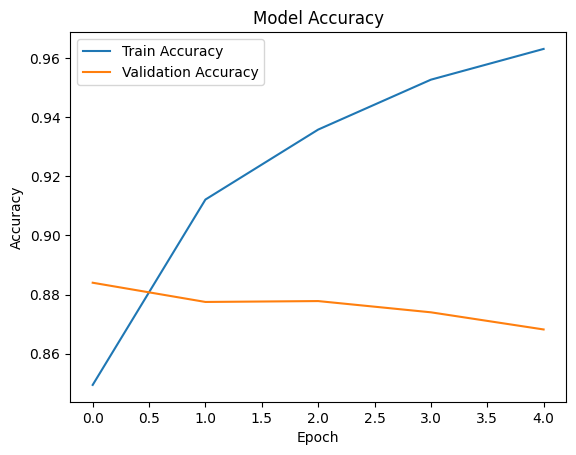

In [9]:
# Plot model training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# Encode target variable for test data
y_test_encoded = label_encoder.transform(y_test)

# Evaluate the model using encoded labels
loss, accuracy = model.evaluate(X_test_pad, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


313/313 [==============================] - 4s 12ms/step - loss: 0.4185 - accuracy: 0.8682
Test Loss: 0.4184599220752716
Test Accuracy: 0.8682000041007996


In [11]:
# Predict probabilities for each class
y_pred_prob = model.predict(X_test_pad)
# Convert probabilities to classes by applying threshold (e.g., 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# In case you have only one output neuron, you can simply use:
# y_pred = (model.predict(X_test_pad) > 0.5).astype(int)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))


313/313 [==============================] - 4s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      4961
           1       0.86      0.89      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [12]:
# Use the model on a random sentence with adjusted threshold
random_sentence = "This movie is absolutely amazing, I would watch it again."
processed_sentence = preprocess_text(random_sentence)
sequence = tokenizer.texts_to_sequences([processed_sentence])
padded_sequence = pad_sequences(sequence, maxlen=max_len)

# Adjust the threshold as needed
threshold = 0.3

# Predict sentiment using the model with the adjusted threshold
prediction = (model.predict(padded_sequence) > threshold).astype(int)

# Output the predicted sentiment
# Check the processed sentence before padding
print("Processed Sentence:", processed_sentence)
print("Predicted Sentiment for Random Sentence:", "Positive" if prediction[0][0] == 1 else "Negative")



1/1 [==============================] - 0s 29ms/step
Processed Sentence: movie absolutely amazing would watch
Predicted Sentiment for Random Sentence: Positive
